# Предложение 5

Ввести райдшеринг

In [42]:
import os
import json
from dotenv import load_dotenv
import clickhouse_connect
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np

In [2]:
# Load configuration
with open('./dags/conf/config.json', 'r') as f:
    CONFIG = json.load(f)

# Shortcut for database name
db = CONFIG['clickhouse']['dbs']['golden_db']
# TODO
CONFIG['clickhouse']['host'] = 'localhost'

# Load credentials
load_dotenv(dotenv_path='./dags/conf/.env', override=True)

True

In [5]:
# Create Clickhouse client
ch_client = clickhouse_connect.get_client(
    host=CONFIG['clickhouse']['host'],
    database=db,
    username=os.getenv('CLICKHOUSE_USER'),
    password=os.getenv('CLICKHOUSE_PASS')
)

In [26]:
# As each ride in materialized view mv_trip_vectors satisfies conditions for ride sharing
# we can just simulate scenarios without additional calculations

# Get only most promissing ride sharing candidates -
# divide vectors into 4 groups by revenue and take the most promissing
sql = f"""
    SELECT vector, `hour`, `minute`, rides_count, avg_fare, avg_distance, avg_passengers_count,
            rides_count * avg_fare AS total_fare,
            rides_count * avg_distance AS total_distance,
            ntile(4) OVER (ORDER BY total_fare DESC) AS fare_bucket
        FROM {db}.mv_trip_vectors
            QUALIFY fare_bucket = 1
"""
df = ch_client.query_df(sql)
print(df.head(10))

                                              vector  hour  minute  \
0  Manhattan.East Harlem South->Manhattan.East Ha...    17      15   
1  Manhattan.East Harlem South->Manhattan.East Ha...    17      10   
2  Manhattan.East Harlem South->Manhattan.East Ha...    17       5   
3  Manhattan.East Harlem South->Manhattan.East Ha...    17      20   
4  Manhattan.East Harlem North->Manhattan.East Ha...     8      40   
5  Manhattan.East Harlem North->Manhattan.East Ha...     8      45   
6  Manhattan.East Harlem South->Manhattan.East Ha...    17      25   
7  Manhattan.East Harlem South->Manhattan.East Ha...    16      35   
8  Manhattan.East Harlem South->Manhattan.East Ha...    16      40   
9  Manhattan.East Harlem South->Manhattan.East Ha...    17       0   

   rides_count  avg_fare  avg_distance  avg_passengers_count  total_fare  \
0         1871  6.706040      1.185249                   1.0     12547.0   
1         1787  6.702015      1.185747                   1.0     11976.5   
2

In [27]:
styled = (df.head(20)
    .style
    .format({'avg_fare': '{:.2f}',
            'avg_distance': '{:.2f}',
            'total_fare': '{:.2f}',
            'total_distance': '{:.2f}',
            'avg_passengers_count': '{:.0f}',
            })
    .set_table_styles([
        {"selector": "table", "props": [("border-collapse", "collapse"), ("width", "100%")]},
        {"selector": "th, td", "props": [("border", "1px solid #999"), ("padding", "6px")]},
        {"selector": "th", "props": [("background", "steelblue"), ("text-align", "center")]},
        {"selector": "td", "props": [("background", "white"), ("color", "black")]},
    ])
    # .hide(axis="index")
)

display(styled)

,vector,hour,minute,rides_count,avg_fare,avg_distance,avg_passengers_count,total_fare,total_distance,fare_bucket
0,Manhattan.East Harlem South->Manhattan.East Harlem North,17,15,1871,6.71,1.19,1,12547.00,2217.60,1
1,Manhattan.East Harlem South->Manhattan.East Harlem North,17,10,1787,6.70,1.19,1,11976.50,2118.93,1
2,Manhattan.East Harlem South->Manhattan.East Harlem North,17,5,1727,6.64,1.17,1,11464.00,2028.55,1
3,Manhattan.East Harlem South->Manhattan.East Harlem North,17,20,1691,6.60,1.16,1,11154.50,1968.13,1
4,Manhattan.East Harlem North->Manhattan.East Harlem South,8,40,1354,8.18,1.26,1,11077.50,1705.30,1
5,Manhattan.East Harlem North->Manhattan.East Harlem South,8,45,1372,8.03,1.25,1,11023.50,1721.82,1
6,Manhattan.East Harlem South->Manhattan.East Harlem North,17,25,1661,6.53,1.17,1,10851.00,1943.24,1
7,Manhattan.East Harlem South->Manhattan.East Harlem North,16,35,1560,6.79,1.18,1,10590.00,1839.20,1
8,Manhattan.East Harlem South->Manhattan.East Harlem North,16,40,1583,6.67,1.18,1,10557.00,1860.79,1
9,Manhattan.East Harlem South->Manhattan.East Harlem North,17,0,1579,6.61,1.18,1,10434.00,1856.11,1


In [59]:
results = pd.DataFrame()

# Calculate baseline values
baseline = df[['rides_count', 'total_fare', 'total_distance']].sum()
baseline['Saved Trips'] = 0
baseline['Saved Trips Pct'] = 0
baseline['Saved Distance'] = 0
baseline['Saved Distance Pct'] = 0
baseline['Revenue Change'] = 0
baseline['Revenue Change Pct'] = 0
baseline = baseline.rename({
    'rides_count': 'Total Trips',
    'total_fare': 'Total Fare',
    'total_distance': 'Total Distance'
})
results['baseline'] = baseline

styled = (results
    .style
    .format({'baseline': '{:.2f}'})
    .set_table_styles([
        {"selector": "table", "props": [("border-collapse", "collapse"), ("width", "100%")]},
        {"selector": "th, td", "props": [("border", "1px solid #999"), ("padding", "6px")]},
        {"selector": "th", "props": [("background", "steelblue"), ("text-align", "center")]},
        {"selector": "td", "props": [("background", "white"), ("color", "black")]},
    ])
    # .hide(axis="index")
)

display(styled)

,baseline
Total Trips,10406792.00
Total Fare,74557742.01
Total Distance,12958951.69
Saved Trips,0.00
Saved Trips Pct,0.00
Saved Distance,0.00
Saved Distance Pct,0.00
Revenue Change,0.00
Revenue Change Pct,0.00


In [24]:
# Probability of rides
probability_scenarios = (0.05, 0.1, 0.15)

# Discounts scenarios
discount_scenarios = (0.1, 0.2, 0.3)

In [79]:
# Calculate scenarios
for probability in probability_scenarios:
    for discount in discount_scenarios:
        df_scenario = df.copy()
        # Calculate shared trips consent count
        df_scenario['consent_count'] = round(df_scenario['rides_count'] * probability).astype(int)
        # Calculate passengers count consent for shared trip
        df_scenario['shared_passengers'] = (df_scenario['consent_count'] * df_scenario['avg_passengers_count']).astype(int)
        # Calculate shared trips count
        df_scenario['shared_trips'] = np.ceil(df_scenario['shared_passengers'] / 4).astype(int)
        # Calculate saved trips count
        df_scenario['saved_trips'] = df_scenario['consent_count'] - df_scenario['shared_trips']
        # Calculate saved distance
        df_scenario['saved_distance'] = df_scenario['saved_trips'] * df_scenario['avg_distance']
        # Calculate new revenue
        df_scenario['new_fare'] = df_scenario['total_fare'] - (df_scenario['consent_count'] * df_scenario['avg_fare'] * discount)
        # Calculate new distance
        df_scenario['new_distance'] = df_scenario['total_distance'] - df_scenario['saved_distance']
        # Calculate new trips count
        df_scenario['new_trips'] = df_scenario['rides_count'] - df_scenario['saved_trips']

        scenario_result = df_scenario[['new_trips', 'new_fare', 'new_distance', 'saved_trips', 'saved_distance']].sum()
        scenario_result = scenario_result.rename({
            'new_trips': 'Total Trips',
            'new_fare': 'Total Fare',
            'new_distance': 'Total Distance',
            'saved_trips': 'Saved Trips',
            'saved_distance': 'Saved Distance'
        })
        scenario_result['Saved Trips Pct'] = (1 - scenario_result['Total Trips'] / results['baseline'].loc['Total Trips']) * 100
        scenario_result['Saved Distance Pct'] = (1 - scenario_result['Total Distance'] / results['baseline'].loc['Total Distance']) * 100
        scenario_result['Revenue Change'] = scenario_result['Total Fare'] - results['baseline'].loc['Total Fare']
        scenario_result['Revenue Change Pct'] = (scenario_result['Revenue Change'] / results['baseline'].loc['Total Fare']) * 100

        results[f'Probability {probability} - Discount {discount}'] = scenario_result

print(results.head(10))

                        baseline  Probability 0.05 - Discount 0.1  \
Total Trips         1.040679e+07                     1.007881e+07   
Total Fare          7.455774e+07                     7.418102e+07   
Total Distance      1.295895e+07                     1.256705e+07   
Saved Trips         0.000000e+00                     3.279840e+05   
Saved Trips Pct     0.000000e+00                     3.151634e+00   
Saved Distance      0.000000e+00                     3.918995e+05   
Saved Distance Pct  0.000000e+00                     3.024161e+00   
Revenue Change      0.000000e+00                    -3.767205e+05   
Revenue Change Pct  0.000000e+00                    -5.052735e-01   

                    Probability 0.05 - Discount 0.2  \
Total Trips                            1.007881e+07   
Total Fare                             7.380430e+07   
Total Distance                         1.256705e+07   
Saved Trips                            3.279840e+05   
Saved Trips Pct                   

In [80]:
styled = (results
    .style
    .format('{:.2f}')
    .set_table_styles([
        {"selector": "table", "props": [("border-collapse", "collapse"), ("width", "100%")]},
        {"selector": "th, td", "props": [("border", "1px solid #999"), ("padding", "6px")]},
        {"selector": "th", "props": [("background", "steelblue"), ("text-align", "center")]},
        {"selector": "td", "props": [("background", "white"), ("color", "black")]},
    ])
    # .hide(axis="index")
)

display(styled)

,baseline,Probability 0.05 - Discount 0.1,Probability 0.05 - Discount 0.2,Probability 0.05 - Discount 0.3,Probability 0.1 - Discount 0.1,Probability 0.1 - Discount 0.2,Probability 0.1 - Discount 0.3,Probability 0.15 - Discount 0.1,Probability 0.15 - Discount 0.2,Probability 0.15 - Discount 0.3
Total Trips,10406792.00,10078808.00,10078808.00,10078808.00,9677773.00,9677773.00,9677773.00,9280428.00,9280428.00,9280428.00
Total Fare,74557742.01,74181021.51,73804301.02,73427580.52,73812279.58,73066817.14,72321354.71,73438368.86,72318995.72,71199622.57
Total Distance,12958951.69,12567052.14,12567052.14,12567052.14,12066765.83,12066765.83,12066765.83,11567040.91,11567040.91,11567040.91
Saved Trips,0.00,327984.00,327984.00,327984.00,729019.00,729019.00,729019.00,1126364.00,1126364.00,1126364.00
Saved Trips Pct,0.00,3.15,3.15,3.15,7.01,7.01,7.01,10.82,10.82,10.82
Saved Distance,0.00,391899.55,391899.55,391899.55,892185.86,892185.86,892185.86,1391910.78,1391910.78,1391910.78
Saved Distance Pct,0.00,3.02,3.02,3.02,6.88,6.88,6.88,10.74,10.74,10.74
Revenue Change,0.00,-376720.50,-753440.99,-1130161.49,-745462.43,-1490924.87,-2236387.30,-1119373.15,-2238746.29,-3358119.44
Revenue Change Pct,0.00,-0.51,-1.01,-1.52,-1.00,-2.00,-3.00,-1.50,-3.00,-4.50


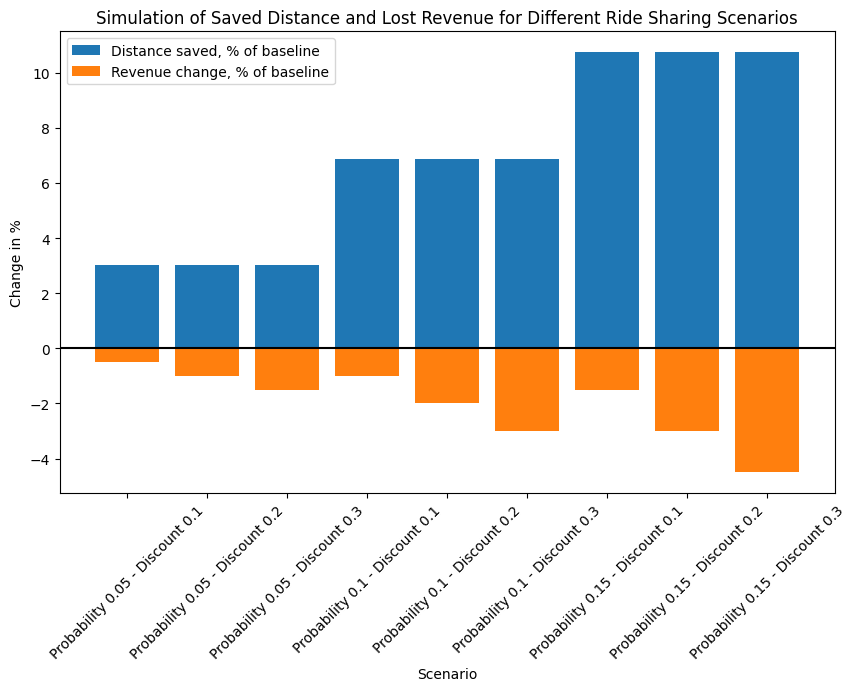

In [103]:
# Plot results
results_plot = results.drop(['baseline'], axis=1).T
plt.figure(figsize=(10,6))

# for column in results.columns:
plt.bar(x=results_plot.index, height=results_plot['Saved Distance Pct'], label=f'Distance saved, % of baseline')
plt.bar(x=results_plot.index, height=results_plot['Revenue Change Pct'], label=f'Revenue change, % of baseline')
plt.axhline(y=0, color='black')

plt.xlabel('Scenario')
plt.xticks(rotation=45)
plt.ylabel('Change in %')
plt.title('Simulation of Saved Distance and Lost Revenue for Different Ride Sharing Scenarios')
plt.legend()

plt.show()